In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score

from keras.layers import Dense,Dropout,LSTM, GRU, SimpleRNN
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers import ConvLSTM2D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Sequential
from keras.losses import mean_squared_error
from keras.backend import sign
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers
from sklearn.metrics import accuracy_score


2022-04-21 00:48:52.407841: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-21 00:48:52.407864: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Data Processing

In [2]:
# read data from AEP hourly
fpath='eye_state.csv'
df=pd.read_csv(fpath, header=0, names=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', 'Target'])
df.head()

1        2        3        4        5        6        7        8  \
0  4324.62  4004.62  4293.85  4148.72  4342.05  4586.67  4097.44  4638.97   
1  4327.69  4006.67  4295.38  4156.41  4336.92  4583.59  4096.92  4630.26   
2  4328.72  4011.79  4296.41  4155.90  4343.59  4582.56  4097.44  4630.77   
3  4326.15  4011.79  4292.31  4151.28  4347.69  4586.67  4095.90  4627.69   
4  4321.03  4004.62  4284.10  4153.33  4345.64  4587.18  4093.33  4616.92   

         9       10       11       12       13       14  Target  
0  4210.77  4226.67  4207.69  4279.49  4632.82  4384.10       0  
1  4207.69  4222.05  4206.67  4282.05  4628.72  4389.23       0  
2  4217.44  4235.38  4210.77  4287.69  4632.31  4396.41       0  
3  4210.77  4244.10  4212.82  4288.21  4632.82  4398.46       0  
4  4202.56  4232.82  4209.74  4281.03  4628.21  4389.74       0

In [3]:
# check missing data in file
df.isna().sum()

1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
Target    0
dtype: int64

In [6]:
# normalize the data
scaler = StandardScaler() 
scaled_values = scaler.fit_transform(df) 
df.loc[:,:] = scaled_values
df.head()

1         2         3         4         5         6         7  \
0  0.001085 -0.112049  0.671413 -0.003111  0.008909 -0.019610 -0.002817   
1  0.002316 -0.067427  0.705851 -0.001637 -0.138765 -0.020663 -0.002930   
2  0.002730  0.044018  0.729035 -0.001734  0.053240 -0.021016 -0.002817   
3  0.001698  0.044018  0.636750 -0.002620  0.171264 -0.019610 -0.003152   
4 -0.000356 -0.112049  0.451955 -0.002227  0.112252 -0.019436 -0.003710   

          8         9        10        11        12        13        14  \
0  0.782290 -0.003771 -0.122092  0.138509  0.006194  0.014578 -0.005489   
1  0.484938 -0.005213 -0.243509  0.111515  0.067815  0.011185 -0.004618   
2  0.502349 -0.000649  0.106812  0.220021  0.203573  0.014156 -0.003399   
3  0.397201 -0.003771  0.335979  0.274274  0.216090  0.014578 -0.003052   
4  0.029522 -0.007614  0.039533  0.192762  0.043263  0.010763 -0.004532   

     Target  
0 -0.902395  
1 -0.902395  
2 -0.902395  
3 -0.902395  
4 -0.902395

In [7]:
# prepare df for target results
y=pd.DataFrame({'Target':df['Target']})
y['Target']=y['Target'].astype(int)
y.head()

Target
0       0
1       0
2       0
3       0
4       0

In [8]:
# remove results from the input df
df = df.drop(columns=['Target'])
df.head()

1         2         3         4         5         6         7  \
0  0.001085 -0.112049  0.671413 -0.003111  0.008909 -0.019610 -0.002817   
1  0.002316 -0.067427  0.705851 -0.001637 -0.138765 -0.020663 -0.002930   
2  0.002730  0.044018  0.729035 -0.001734  0.053240 -0.021016 -0.002817   
3  0.001698  0.044018  0.636750 -0.002620  0.171264 -0.019610 -0.003152   
4 -0.000356 -0.112049  0.451955 -0.002227  0.112252 -0.019436 -0.003710   

          8         9        10        11        12        13        14  
0  0.782290 -0.003771 -0.122092  0.138509  0.006194  0.014578 -0.005489  
1  0.484938 -0.005213 -0.243509  0.111515  0.067815  0.011185 -0.004618  
2  0.502349 -0.000649  0.106812  0.220021  0.203573  0.014156 -0.003399  
3  0.397201 -0.003771  0.335979  0.274274  0.216090  0.014578 -0.003052  
4  0.029522 -0.007614  0.039533  0.192762  0.043263  0.010763 -0.004532

In [25]:
# change input format from df to array
df=np.array(df)
y=np.array(y)

# split the data into test and train
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3)
print("Input shape ", df.shape)
print("Train data shapes ", X_train.shape,", ", y_train.shape) 
print("Test data shapes ", X_test.shape,", ", y_test.shape)

Input shape  (14979, 14)
Train data shapes  (10485, 14) ,  (10485, 1)
Test data shapes  (4494, 14) ,  (4494, 1)


In [26]:
# change input dimensions to 3 for LSTM input
X_train = np.reshape(X_train, (10485, 14, 1))
X_test = np.reshape(X_test, (4494, 14, 1))
print("Input shape ", df.shape)
print("Train data shapes ", X_train.shape,", ", y_train.shape) 
print("Test data shapes ", X_test.shape,", ", y_test.shape)

Input shape  (14979, 14)
Train data shapes  (10485, 14, 1) ,  (10485, 1)
Test data shapes  (4494, 14, 1) ,  (4494, 1)


# General Functions

In [58]:
def get_result(model, X_test, y_test, model_name="Test"): 
    print(f"Model - {model_name}:")
    
    predictions = model.predict(X_test)
    y_test=y_test.astype('int32')
    acc=accuracy_score(y_test, (predictions> 0.5).astype(int))
    print("Accuracy Score:",acc)
    return model.predict(X_test)

def plot_predictions(test, predicted, title="Test", xLabel="Test", yLabel="Test", realLabel="Test", predictedLabel="Test"):
    plt.figure(figsize=(20,8))
    plt.rcParams.update({'font.size': 18})
    plt.plot(test, color='red',label=realLabel)
    plt.plot(predicted, alpha=0.7, color='blue',label=predictedLabel)
    plt.title(title)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.legend()
    plt.show()

### Models in Functions

In [13]:
def lstm(X_train,y_train):
    lstm_model = Sequential()

    lstm_model.add(LSTM(128, input_shape=(X_train.shape[1], 1)))
    lstm_model.add(Dropout(0.15))
    lstm_model.add(Dense(1, activation="sigmoid"))

    lstm_model.summary()
    adam_modified = optimizers.Adam(learning_rate=0.005, beta_1=0.7, beta_2=0.9, amsgrad=False)
    # train LSTM model
    lstm_model.compile(loss="binary_crossentropy", optimizer=adam_modified, metrics=["accuracy"])
    lstm_model.fit(X_train, y_train, epochs=80)
    return lstm_model

In [36]:
def stacked_lstm(X_train,y_train):
# build Stacked_LSTM model
    s_lstm_model = Sequential()

    s_lstm_model.add(LSTM(X_train.shape[1],return_sequences=True,activation="tanh", input_shape=(X_train.shape[1],1)))
    s_lstm_model.add(Dropout(0.15))
    s_lstm_model.add(LSTM(15, return_sequences=False))
    s_lstm_model.add(Dropout(0.2))
    s_lstm_model.add(Dense(1))
    s_lstm_model.summary()

    s_lstm_model.compile(optimizer="adam",loss="MSE")
    s_lstm_model.fit(X_train, y_train, epochs=10)
    return s_lstm_model

In [27]:
def gru(X_train,y_train):
    # build GRU model
    gru_model = Sequential()

    gru_model.add(GRU(X_train.shape[1],activation="tanh", input_shape=(X_train.shape[1],1)))
    gru_model.add(Dropout(0.15))

    gru_model.add(Dense(1))

    gru_model.summary()

    gru_model.compile(optimizer="adam",loss="MSE")
    gru_model.fit(X_train, y_train, epochs=10)
    return gru_model

In [28]:
def rnn(X_train,y_train):
    rnn_model = Sequential()

    rnn_model.add(SimpleRNN(X_train.shape[1],activation="tanh", input_shape=(X_train.shape[1],1)))
    rnn_model.add(Dropout(0.15))

    rnn_model.add(Dense(1))

    rnn_model.summary()

    rnn_model.compile(optimizer="adam",loss="MSE")
    rnn_model.fit(X_train, y_train, epochs=10)
    return rnn_model


In [29]:
def cnn(X_train,y_train):
    cnn_model = Sequential()
    cnn_model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1],1)))
    cnn_model.add(MaxPooling1D(pool_size=2))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(10, activation='relu'))
    cnn_model.add(Dense(1))
    cnn_model.summary()
    cnn_model.compile(optimizer='adam', loss='mse')



    cnn_model.compile(optimizer="adam",loss="MSE")
    cnn_model.fit(X_train, y_train, epochs=10)
    return cnn_model

# Training and fitting models

In [63]:
lstm_model=lstm(X_train,y_train)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
328/328 [==============================] - 5s 12ms/step - loss: 0.6770 - accuracy: 0.5692
Epoch 2/80
328/328 [==============================] - 4s 11ms/step - loss: 0.6598 - accuracy: 0.5890
Epoch 3/80
328/328 [==============================] - 4s 11ms/step - loss: 0.6312 - accuracy: 0.6258
Epoch 4/80


In [64]:
lstm_predictions = get_result(lstm_model, X_test, y_test, "LSTM")
#plot_predictions(y_test, lstm_predictions, "LSTM model", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - LSTM:
Accuracy Score: 0.8210947930574098


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 23, 23)            2300      
                                                                 
 dropout_1 (Dropout)         (None, 23, 23)            0         
                                                                 
 lstm_2 (LSTM)               (None, 15)                2340      
                                                                 
 dropout_2 (Dropout)         (None, 15)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 16        
                                                                 
Total params: 4,656
Trainable params: 4,656
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
127/127 [==============================] 

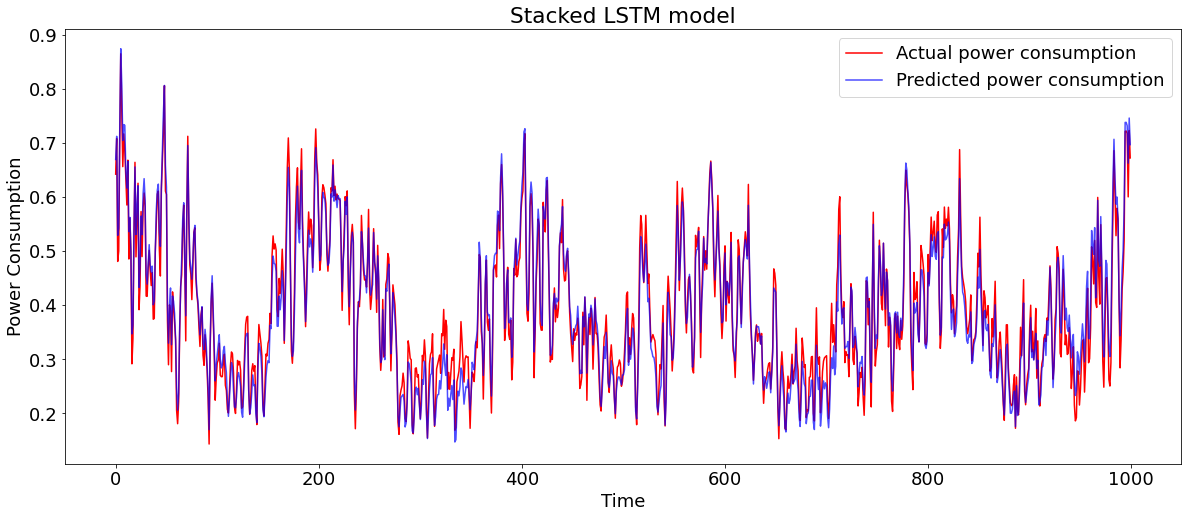

In [13]:
# build Stacked_LSTM model
s_lstm_model = stacked_lstm(X_train,y_train)


s_lstm_predictions = get_result(s_lstm_model, X_test, y_test, "Stacked LSTM")
plot_predictions(y_test, s_lstm_predictions, "Stacked LSTM model", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 23)                1794      
                                                                 
 dropout_3 (Dropout)         (None, 23)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 24        
                                                                 
Total params: 1,818
Trainable params: 1,818
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
127/127 [==============================] - 2s 6ms/step - loss: 0.0209
Epoch 2/10
127/127 [==============================] - 1s 6ms/step - loss: 0.0070
Epoch 3/10
127/127 [==============================] - 1s 6ms/step - loss: 0.0044
Epoch 4/10
127/127 [==============================] - 1s 6ms/step - loss:

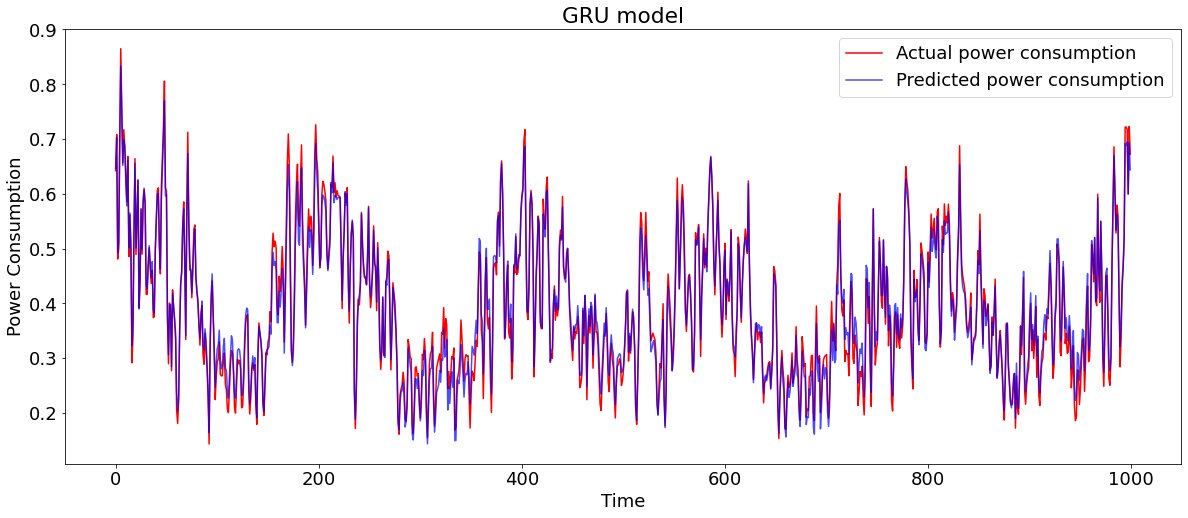

In [14]:
gru_model=gru(X_train,y_train)
gru_predictions = get_result(gru_model, X_test, y_test, "GRU")
plot_predictions(y_test, gru_predictions, "GRU model", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 23)                575       
                                                                 
 dropout_13 (Dropout)        (None, 23)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 24        
                                                                 
Total params: 599
Trainable params: 599
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
127/127 [==============================] - 1s 3ms/step - loss: 0.0117
Epoch 2/10
127/127 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 3/10
127/127 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 4/10
127/127 [==============================] - 0s 3ms/step - loss: 0.

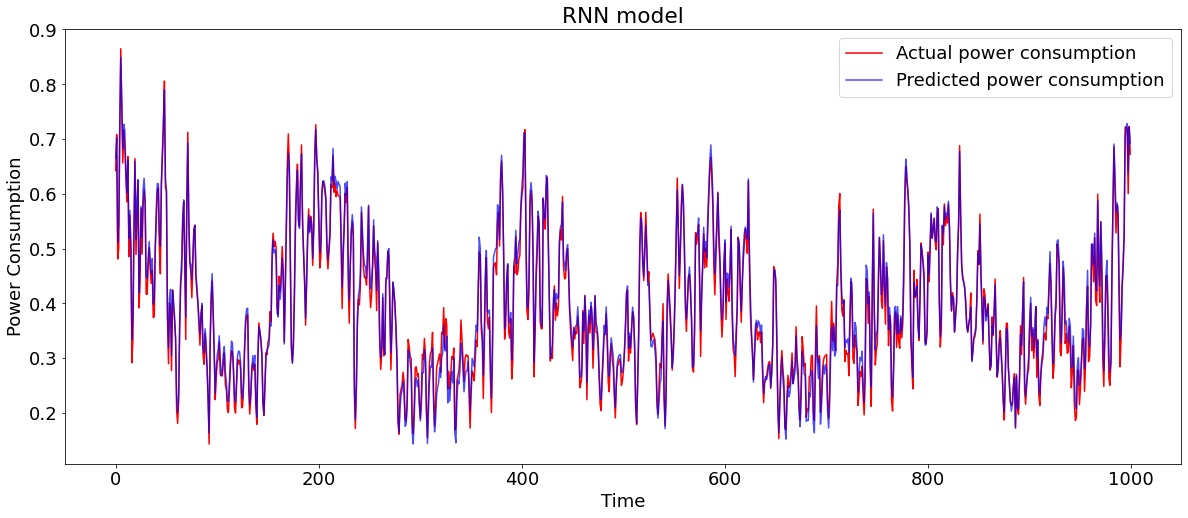

In [74]:
# build RNN model
rnn_model=rnn(X_train,y_train)
rnn_predictions = get_result(rnn_model, X_test, y_test, "RNN")
plot_predictions(y_test, rnn_predictions, "RNN model", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 22, 64)            192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 11, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 704)               0         
                                                                 
 dense_13 (Dense)            (None, 10)                7050      
                                                                 
 dense_14 (Dense)            (None, 1)                 11        
                                                                 
Total params: 7,253
Trainable params: 7,253
Non-trainable params: 0
___________________________________________________

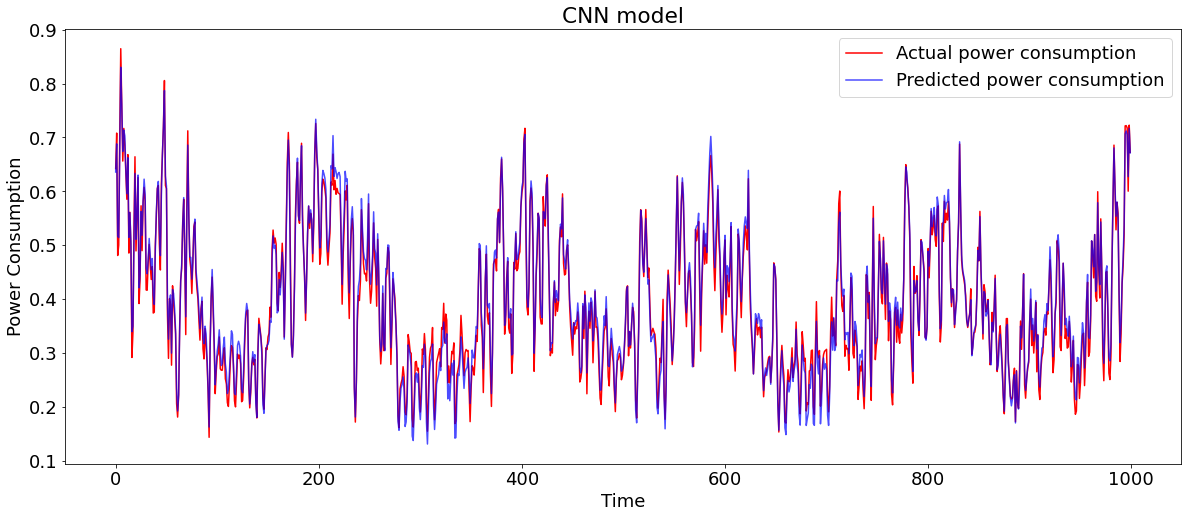

In [85]:
# build CNN model
 

cnn_model=cnn(X_train,y_train)
cnn_predictions = get_result(cnn_model, X_test, y_test, "CNN")
plot_predictions(y_test, cnn_predictions, "CNN model", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")


In [ ]:
# build CNN-LSTM model
n_seq = 1
X_train_reshaped = X_train.reshape((X_train.shape[0], n_seq, X_train.shape[1], 1))

cnn_lstm_model = Sequential()
cnn_lstm_model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train.shape[1],1)))
cnn_lstm_model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
cnn_lstm_model.add(TimeDistributed(Flatten()))
cnn_lstm_model.add(LSTM(20, activation='relu'))
cnn_lstm_model.add(Dense(1))
 
cnn_lstm_model.summary()
cnn_lstm_model.compile(optimizer='adam', loss='mse')


cnn_lstm_model.compile(optimizer="adam",loss="MSE")
cnn_lstm_model.fit(X_train_reshaped, y_train, epochs=10)

cnn_lstm_predictions = get_result(cnn_lstm_model, X_test.reshape((X_test.shape[0], n_seq, X_test.shape[1], 1)), y_test, "CNN-LSTM")
plot_predictions(y_test, cnn_lstm_predictions, "CNN-LSTM model", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")


In [ ]:
# build ConvLSTM model
n_seq = 1
n_features = 1
X_train_reshaped = X_train.reshape((X_train.shape[0], n_seq, 1, X_train.shape[1], n_features))

conv_lstm_model = Sequential()
conv_lstm_model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, X_train.shape[1], n_features)))
conv_lstm_model.add(Flatten())
conv_lstm_model.add(Dense(1))
conv_lstm_model.summary()

conv_lstm_model.compile(optimizer="adam",loss="MSE")
conv_lstm_model.fit(X_train_reshaped, y_train, epochs=10)

conv_lstm_predictions = get_result(conv_lstm_model, X_test.reshape((X_test.shape[0], n_seq, 1, X_test.shape[1], n_features)), y_test, "ConvLSTM")
plot_predictions(y_test, conv_lstm_predictions, "ConvLSTM model", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")


# Adversarial Attacks

## Attack Functions

In [65]:
def signed_gradient(X_test, y): 
    y =  y[:,0].astype(dtype=np.float32)
    X_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(X_tf)
        lossFunction = mean_squared_error(X_tf, y.reshape(-1))
    gradientFunction = tape.gradient(lossFunction, X_tf)
    signed_grad = tf.sign(gradientFunction)
    return signed_grad.numpy()

def fgsm(X_test, y, epsilon=0.1):
    signed_grad = signed_gradient(X_test, y)
    X_perturbed = X_test + epsilon * signed_grad
    return X_perturbed

def bim(iterations, epsilon, alpha, X_test, y, final_X_only = True):
    X_perturbed = X_test.copy()
    for i in range(iterations):
        n = alpha * signed_gradient(X_perturbed, y)
        X_perturbed += n
        maxValues = np.maximum((X_test-epsilon), np.array(X_perturbed)) 
        X_perturbed = np.minimum((X_test+epsilon), maxValues)
       
        return X_perturbed
def pgd(iterations, epsilon, alpha, X_test, y, final_X_only = True):
    X_perturbed = X_test + np.random.uniform(-epsilon,epsilon,X_test.shape)
    for i in range(iterations):
        n = alpha * signed_gradient(X_perturbed, y)
        X_perturbed += n
        maxValues = np.maximum((X_test-epsilon), np.array(X_perturbed)) 
        X_perturbed = np.minimum((X_test+epsilon), maxValues)
        
        
        return X_perturbed

## Attacks on Models

### Attacks on LSTM

In [66]:
X_fgsm_perturbed_lstm = fgsm(X_test, y_test, epsilon=0.1) 
fgsm_predictions_lstm = get_result(lstm_model, X_fgsm_perturbed_lstm, y_test, "FGSM perturbed LSTM")
#plot_predictions(y_test, fgsm_predictions_lstm, "FGSM perturbed LSTM", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - FGSM perturbed LSTM:
Accuracy Score: 0.7434356920338229


In [61]:
# run this to show intermediate results
# bim(lstm_model, 5, 0.1, 0.05, X_test, y_test, final_X_only = False)

In [67]:
X_bim_perturbed_lstm = bim(5, 0.1, 0.05, X_test, y_test)
bim_predictions_lstm = get_result(lstm_model, X_bim_perturbed_lstm, y_test, "BIM perturbed LSTM")
#plot_predictions(y_test, bim_predictions_lstm, "BIM perturbed LSTM", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - BIM perturbed LSTM:
Accuracy Score: 0.8030707610146862


In [26]:
# run this to show intermediate results
# pgd(lstm_model, 5, 0.1, 0.05, X_test, y_test, final_X_only =False)

In [68]:
X_pgd_perturbed_lstm = pgd(5, 0.1, 0.05, X_test, y_test)
pgd_predictions_lstm = get_result(lstm_model, X_pgd_perturbed_lstm, y_test, "PGD perturbed LSTM")
#plot_predictions(y_test, pgd_predictions_lstm, "PGD perturbed LSTM", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - PGD perturbed LSTM:
Accuracy Score: 0.7676902536715621


### Attacks on Stacked LSTM

In [29]:
# need to copy the same things above
# replace the variable names carefully


In [30]:
X_fgsm_perturbed_stlstm = fgsm(X_test, y_test, epsilon=0.1) 
fgsm_predictions_stlstm = get_result(s_lstm_model, X_fgsm_perturbed_stlstm, y_test, "FGSM perturbed Stacked LSTM")
plot_predictions(y_test, fgsm_predictions_stlstm, "FGSM perturbed Stacked LSTM", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - FGSM perturbed Stacked LSTM:
R^2 Score: 0.5173464758549704
RMSE: 0.08856169097863342


In [31]:
'''
X_bim_perturbed_stlstm = bim(5, 0.1, 0.05, X_test, y_test)
bim_predictions_stlstm = get_result(s_lstm_model, X_bim_perturbed_stlstm, y_test, "BIM perturbed Stacked LSTM")
plot_predictions(y_test, bim_predictions_stlstm, "BIM perturbed Stacked LSTM", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")
'''

'\nX_bim_perturbed_stlstm = bim(5, 0.1, 0.05, X_test, y_test)\nbim_predictions_stlstm = get_result(s_lstm_model, X_bim_perturbed_stlstm, y_test, "BIM perturbed Stacked LSTM")\nplot_predictions(y_test, bim_predictions_stlstm, "BIM perturbed Stacked LSTM", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")\n'

In [32]:
X_pgd_perturbed_stlstm = pgd(5, 0.1, 0.05, X_test, y_test)
pgd_predictions_stlstm = get_result(s_lstm_model, X_pgd_perturbed_stlstm, y_test, "PGD perturbed Stacked LSTM")
plot_predictions(y_test, pgd_predictions_stlstm, "PGD perturbed Stacked LSTM", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - PGD perturbed Stacked LSTM:
R^2 Score: 0.7882454577895944
RMSE: 0.05866033625062292


### Attacks on GRU

In [33]:
# need to copy the same things above
# replace the variable names carefully
X_fgsm_perturbed_gru = fgsm(X_test, y_test, epsilon=0.1) 
fgsm_predictions_gru = get_result(gru_model, X_fgsm_perturbed_gru, y_test, "FGSM perturbed GRU")
plot_predictions(y_test, fgsm_predictions_gru, "FGSM perturbed GRU", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - FGSM perturbed GRU:
R^2 Score: 0.4923832551035857
RMSE: 0.0908230606811819


In [34]:
'''
X_bim_perturbed_gru = bim(5, 0.1, 0.05, X_test, y_test)
bim_predictions_gru = get_result(gru_model, X_bim_perturbed_gru, y_test, "BIM perturbed GRU")
plot_predictions(y_test, bim_predictions_gru, "BIM perturbed GRU", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")
'''

'\nX_bim_perturbed_gru = bim(5, 0.1, 0.05, X_test, y_test)\nbim_predictions_gru = get_result(gru_model, X_bim_perturbed_gru, y_test, "BIM perturbed GRU")\nplot_predictions(y_test, bim_predictions_gru, "BIM perturbed GRU", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")\n'

In [35]:
X_pgd_perturbed_gru = pgd(5, 0.1, 0.05, X_test, y_test)
pgd_predictions_gru = get_result(gru_model, X_pgd_perturbed_gru, y_test, "PGD perturbed GRU")
plot_predictions(y_test, pgd_predictions_gru, "PGD perturbed GRU", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - PGD perturbed GRU:
R^2 Score: 0.6150540602817282
RMSE: 0.0790911744207816


### Attacks on RNN

In [36]:
# need to copy the same things above
# replace the variable names carefully

Model - FGSM perturbed RNN:
R^2 Score: 0.39081822368200525
RMSE: 0.09949507887719822


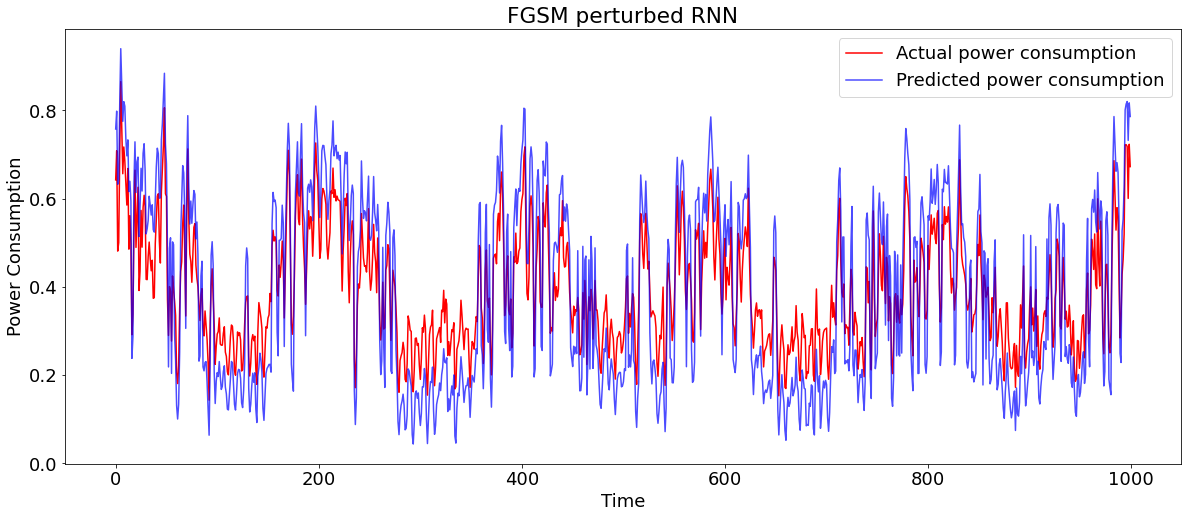

In [75]:
X_fgsm_perturbed_rnn = fgsm(X_test, y_test, epsilon=0.1) 
fgsm_predictions_rnn = get_result(rnn_model, X_fgsm_perturbed_rnn, y_test, "FGSM perturbed RNN")
plot_predictions(y_test, fgsm_predictions_rnn, "FGSM perturbed RNN", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

In [76]:
X_pgd_perturbed_rnn = pgd(5, 0.1, 0.05, X_test, y_test)
pgd_predictions_rnn = get_result(rnn_model, X_pgd_perturbed_rnn, y_test, "PGD perturbed RNN")
plot_predictions(y_test, pgd_predictions_rnn, "PGD perturbed RNN", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - PGD perturbed RNN:
R^2 Score: 0.5705283216886989
RMSE: 0.08354018814971712


### Attacks on CNN

In [ ]:
# need to copy the same things above
# replace the variable names carefully

Model - FGSM perturbed CNN:
R^2 Score: 0.35378137879194016
RMSE: 0.1024749873552759


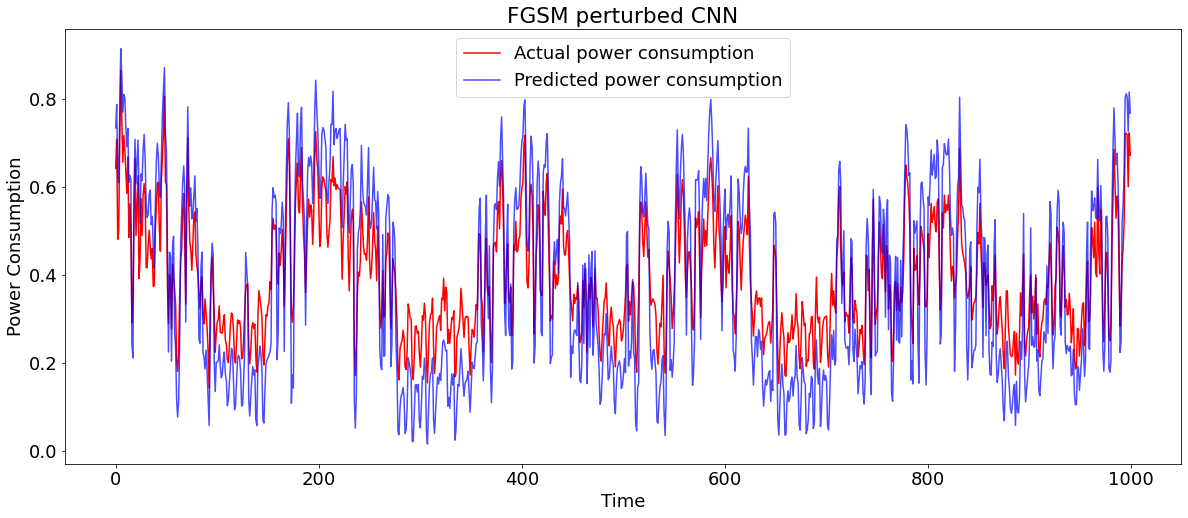

In [86]:
X_fgsm_perturbed_cnn = fgsm(X_test, y_test, epsilon=0.1) 
fgsm_predictions_cnn = get_result(cnn_model, X_fgsm_perturbed_cnn, y_test, "FGSM perturbed CNN")
plot_predictions(y_test, fgsm_predictions_cnn, "FGSM perturbed CNN", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

In [87]:
X_pgd_perturbed_cnn = pgd(5, 0.1, 0.05, X_test, y_test)
pgd_predictions_cnn = get_result(cnn_model, X_pgd_perturbed_cnn, y_test, "PGD perturbed CNN")
plot_predictions(y_test, pgd_predictions_cnn, "PGD perturbed CNN", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - PGD perturbed CNN:
R^2 Score: 0.5655116777974726
RMSE: 0.08402668087000753


### Attacks on CNN-LSTM

In [ ]:
# need to copy the same things above
# replace the variable names carefully

### Attacks on ConvLSTM

In [ ]:
# need to copy the same things above
# replace the variable names carefully

## Adversarial Learning

In [37]:
new_Y=np.concatenate((y_train,y_train))

In [38]:
# Create perturbed training set
X_fgsm_perturbed_train = fgsm(X_train, y_train, epsilon=0.1)
X_new_fgsm=np.concatenate((X_train,X_fgsm_perturbed_train))
fgsm_lstm=lstm(X_new_fgsm,new_Y)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 23)                2300      
                                                                 
 dropout_4 (Dropout)         (None, 23)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 24        
                                                                 
Total params: 2,324
Trainable params: 2,324
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
254/254 [==============================] - 4s 6ms/step - loss: 0.0164
Epoch 2/10
254/254 [==============================] - 1s 6ms/step - loss: 0.0067
Epoch 3/10
254/254 [==============================] - 1s 6ms/step - loss: 0.0049
Epoch 4/10
254/254 [==============================] - 1s 6ms/step - loss:

Model - FGSM-LSTM:
R^2 Score: 0.9028648663890972
RMSE: 0.039729794937610675


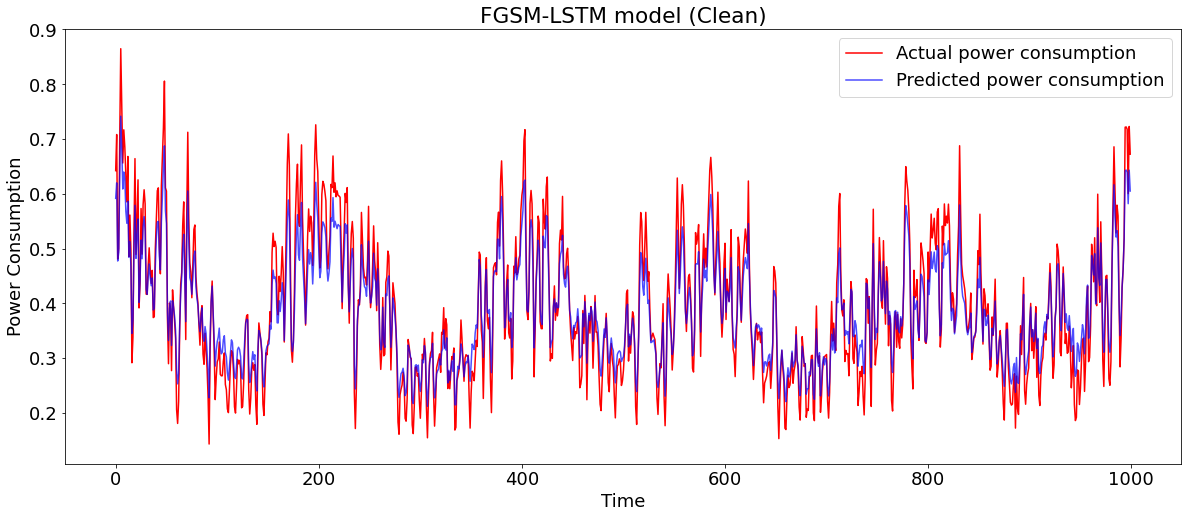

In [39]:
lstm_fgsm_predictions=get_result(fgsm_lstm, X_test, y_test, "FGSM-LSTM")
plot_predictions(y_test, lstm_fgsm_predictions, "FGSM-LSTM model (Clean)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - FGSM-LSTM:
R^2 Score: 0.8746249225497907
RMSE: 0.045137110043640814


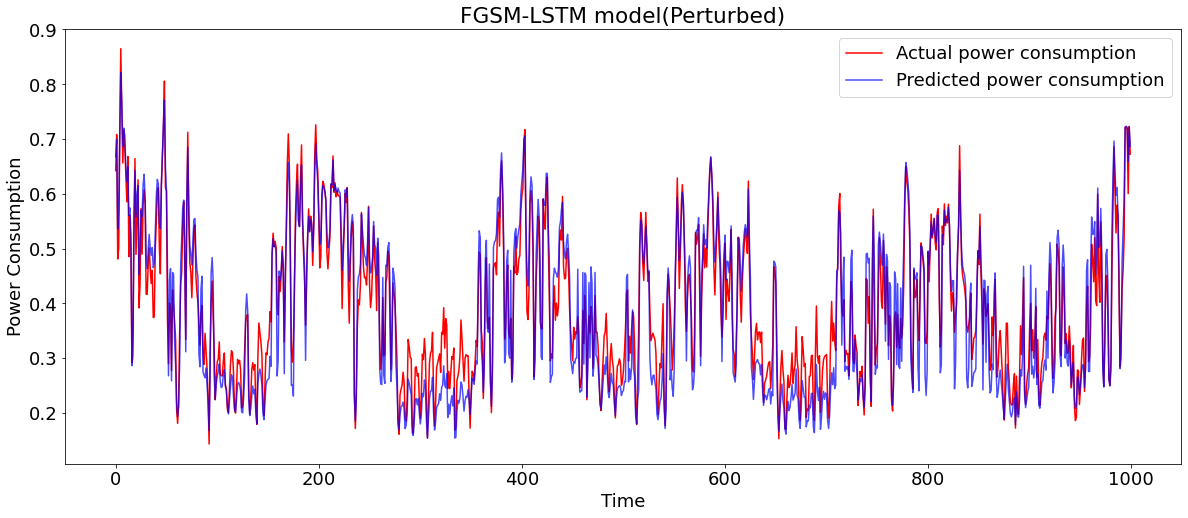

In [47]:
lstm_fgsm_predictions=get_result(fgsm_lstm, X_fgsm_perturbed_lstm, y_test, "FGSM-LSTM")
plot_predictions(y_test, lstm_fgsm_predictions, "FGSM-LSTM model(Perturbed)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

In [48]:
'''# Create perturbed training set
X_bim_perturbed_train = bim(5,0.1,0.05,X_train, y_train)
X_new_bim=np.concatenate((X_train,X_bim_perturbed_train))
bim_lstm=lstm(X_new_bim,new_Y)
'''

'# Create perturbed training set\nX_bim_perturbed_train = bim(5,0.1,0.05,X_train, y_train)\nX_new_bim=np.concatenate((X_train,X_bim_perturbed_train))\nbim_lstm=lstm(X_new_bim,new_Y)\n'

In [49]:
'''
lstm_bim_predictions=get_result(bim_lstm, X_test, y_test, "BIM-LSTM")
plot_predictions(y_test, lstm_bim_predictions, "BIM-LSTM model (Clean)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")
'''

'\nlstm_bim_predictions=get_result(bim_lstm, X_test, y_test, "BIM-LSTM")\nplot_predictions(y_test, lstm_bim_predictions, "BIM-LSTM model (Clean)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")\n'

In [50]:
'''
lstm_bim_predictions=get_result(bim_lstm, X_bim_perturbed_lstm, y_test, "BIM-LSTM")
plot_predictions(y_test, lstm_bim_predictions, "BIM-LSTM model (Perturbed)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")
'''

'\nlstm_bim_predictions=get_result(bim_lstm, X_bim_perturbed_lstm, y_test, "BIM-LSTM")\nplot_predictions(y_test, lstm_bim_predictions, "BIM-LSTM model (Perturbed)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")\n'

In [51]:
# Create perturbed training set
X_pgd_perturbed_train = pgd(5,0.1,0.05,X_train, y_train)
X_new_pgd=np.concatenate((X_train,X_pgd_perturbed_train))
pgd_lstm=lstm(X_new_pgd,new_Y)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 23)                2300      
                                                                 
 dropout_6 (Dropout)         (None, 23)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 24        
                                                                 
Total params: 2,324
Trainable params: 2,324
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
254/254 [==============================] - 3s 6ms/step - loss: 0.0185
Epoch 2/10
254/254 [==============================] - 1s 5ms/step - loss: 0.0069
Epoch 3/10
254/254 [==============================] - 2s 6ms/step - loss: 0.0050
Epoch 4/10
254/254 [==============================] - 2s 6ms/step - loss:

In [52]:
lstm_pgd_predictions=get_result(pgd_lstm, X_test, y_test, "PGS-LSTM")
plot_predictions(y_test, lstm_pgd_predictions, "PGD-LSTM model (Clean)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - PGS-LSTM:
R^2 Score: 0.9322671648630927
RMSE: 0.033176288558412155


In [53]:
lstm_pgd_predictions=get_result(pgd_lstm, X_pgd_perturbed_lstm, y_test, "PGS-LSTM")
plot_predictions(y_test, lstm_pgd_predictions, "PGD-LSTM model (Perturbed)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - PGS-LSTM:
R^2 Score: 0.8528158739603194
RMSE: 0.0489056067835767


#### Stacked LSTM

In [54]:
# Create perturbed training set
X_fgsm_perturbed_train = fgsm(X_train, y_train, epsilon=0.1)
X_new_fgsm=np.concatenate((X_train,X_fgsm_perturbed_train))
fgsm_stlstm=stacked_lstm(X_new_fgsm,new_Y)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 23, 23)            2300      
                                                                 
 dropout_7 (Dropout)         (None, 23, 23)            0         
                                                                 
 lstm_7 (LSTM)               (None, 15)                2340      
                                                                 
 dropout_8 (Dropout)         (None, 15)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 16        
                                                                 
Total params: 4,656
Trainable params: 4,656
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
254/254 [==============================] 

In [55]:
stlstm_fgsm_predictions=get_result(fgsm_stlstm, X_test, y_test, "FGSM-StackedLSTM")
plot_predictions(y_test, stlstm_fgsm_predictions, "FGSM-LSTM model (Clean)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - FGSM-StackedLSTM:
R^2 Score: 0.9042798410027258
RMSE: 0.039439359354895606


Model - FGSM-StackedLSTM:
R^2 Score: 0.8777935719772775
RMSE: 0.04456307858998348


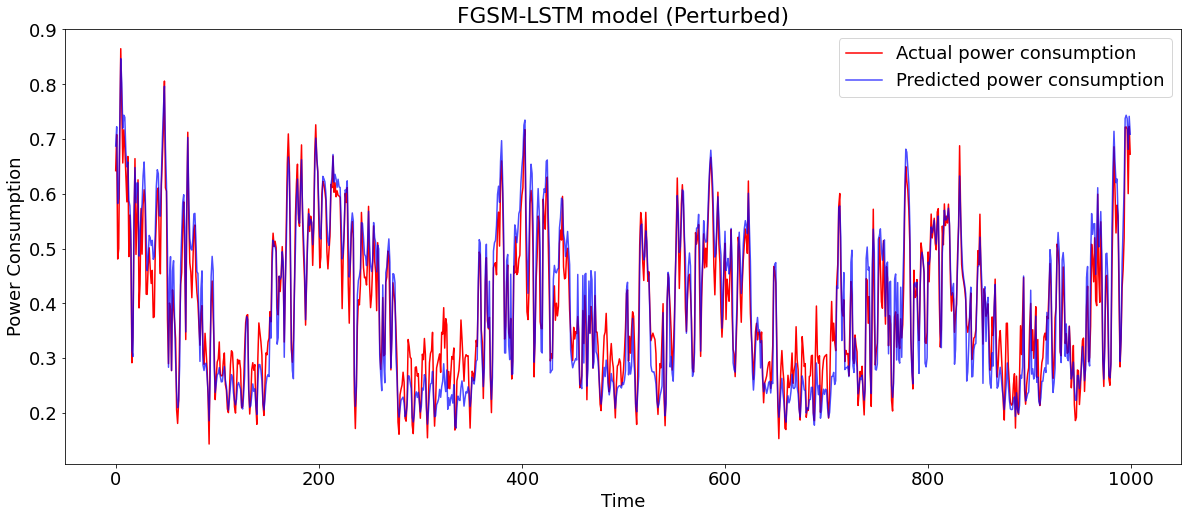

In [57]:
stlstm_fgsm_predictions=get_result(fgsm_stlstm, X_fgsm_perturbed_stlstm, y_test, "FGSM-StackedLSTM")
plot_predictions(y_test, stlstm_fgsm_predictions, "FGSM-LSTM model (Perturbed)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

In [58]:
'''
# Create perturbed training set
X_bim_perturbed_train = bim(5,0.1,0.05,X_train, y_train)
X_new_bim=np.concatenate((X_train,X_bim_perturbed_train))
bim_stlstm=stacked_lstm(X_new_bim,new_Y)
'''

'\n# Create perturbed training set\nX_bim_perturbed_train = bim(5,0.1,0.05,X_train, y_train)\nX_new_bim=np.concatenate((X_train,X_bim_perturbed_train))\nbim_stlstm=stacked_lstm(X_new_bim,new_Y)\n'

In [59]:
'''
stlstm_bim_predictions=get_result(bim_stlstm, X_test, y_test, "BIM-StackedLSTM")
plot_predictions(y_test, stlstm_bim_predictions, "BIM-LSTM model (Clean)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")
'''

'\nstlstm_bim_predictions=get_result(bim_stlstm, X_test, y_test, "BIM-StackedLSTM")\nplot_predictions(y_test, stlstm_bim_predictions, "BIM-LSTM model (Clean)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")\n'

In [60]:
'''
stlstm_bim_predictions=get_result(bim_stlstm, X_bim_perturbed_stlstm, y_test, "BIM-StackedLSTM")
plot_predictions(y_test, stlstm_bim_predictions, "BIM-LSTM model (Perturbed)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")
'''

'\nstlstm_bim_predictions=get_result(bim_stlstm, X_bim_perturbed_stlstm, y_test, "BIM-StackedLSTM")\nplot_predictions(y_test, stlstm_bim_predictions, "BIM-LSTM model (Perturbed)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")\n'

In [62]:
# Create perturbed training set
X_pgd_perturbed_train = pgd(5,0.1,0.05,X_train, y_train)
X_new_pgd=np.concatenate((X_train,X_pgd_perturbed_train))
pgd_stlstm=stacked_lstm(X_new_pgd,new_Y)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 23, 23)            2300      
                                                                 
 dropout_9 (Dropout)         (None, 23, 23)            0         
                                                                 
 lstm_9 (LSTM)               (None, 15)                2340      
                                                                 
 dropout_10 (Dropout)        (None, 15)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 16        
                                                                 
Total params: 4,656
Trainable params: 4,656
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
254/254 [==============================] 

Model - PGD-StackedLSTM:
R^2 Score: 0.9059498125695844
RMSE: 0.03909381118195211


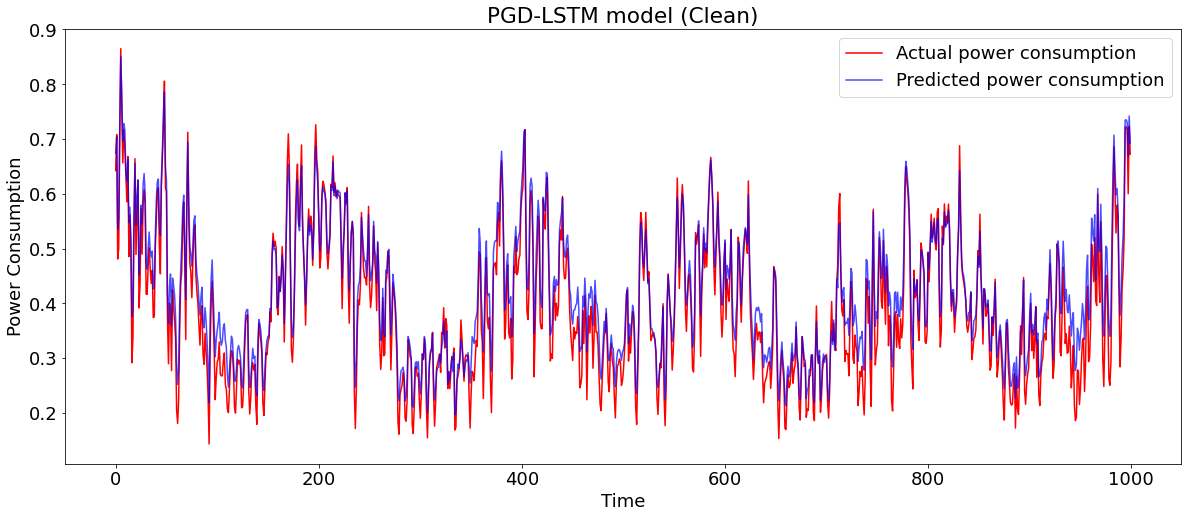

In [63]:
stlstm_pgd_predictions=get_result(pgd_stlstm, X_test, y_test, "PGD-StackedLSTM")
plot_predictions(y_test, stlstm_pgd_predictions, "PGD-LSTM model (Clean)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - PGD-StackedLSTM:
R^2 Score: 0.8156226424737804
RMSE: 0.05473712177024521


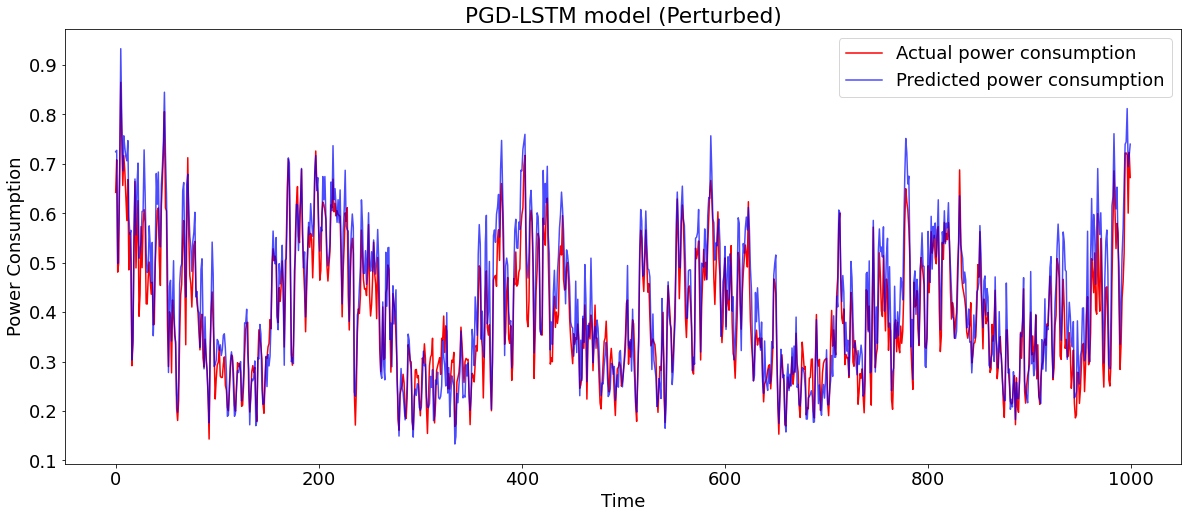

In [65]:
stlstm_pgd_predictions=get_result(pgd_stlstm, X_pgd_perturbed_stlstm, y_test, "PGD-StackedLSTM")
plot_predictions(y_test, stlstm_pgd_predictions, "PGD-LSTM model (Perturbed)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

#### GRU

In [66]:
# Create perturbed training set
X_fgsm_perturbed_train = fgsm(X_train, y_train, epsilon=0.1)
X_new_gru=np.concatenate((X_train,X_fgsm_perturbed_train))
fgsm_gru=gru(X_new_gru,new_Y)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 23)                1794      
                                                                 
 dropout_11 (Dropout)        (None, 23)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 24        
                                                                 
Total params: 1,818
Trainable params: 1,818
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
254/254 [==============================] - 3s 6ms/step - loss: 0.0201
Epoch 2/10
254/254 [==============================] - 2s 6ms/step - loss: 0.0058
Epoch 3/10
254/254 [==============================] - 2s 6ms/step - loss: 0.0046
Epoch 4/10
254/254 [==============================] - 2s 6ms/step - loss:

Model - FGSM-GRU:
R^2 Score: 0.9129876420839655
RMSE: 0.03760266735073348


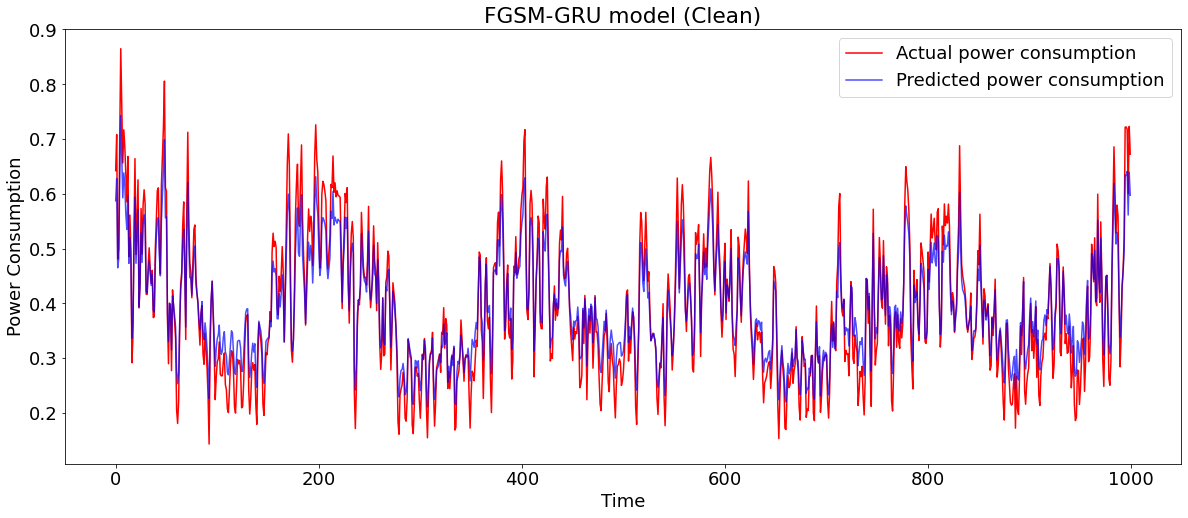

In [67]:
gru_fgsm_predictions=get_result(fgsm_gru, X_test, y_test, "FGSM-GRU")
plot_predictions(y_test, gru_fgsm_predictions, "FGSM-GRU model (Clean)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - FGSM-StackedLSTM:
R^2 Score: 0.8444339286917073
RMSE: 0.05027888156295685


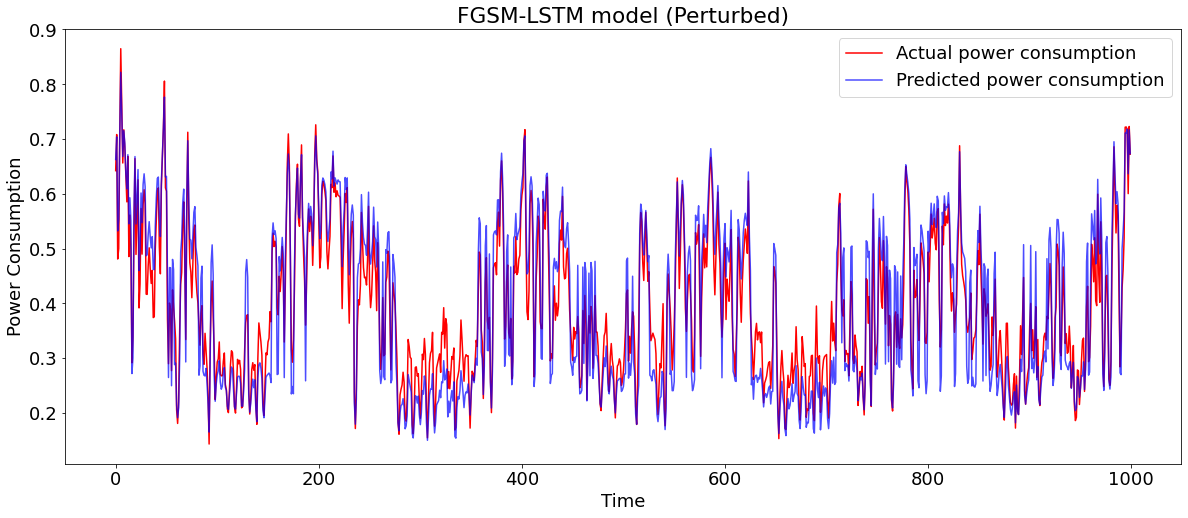

In [68]:
gru_fgsm_predictions=get_result(fgsm_gru, X_fgsm_perturbed_gru, y_test, "FGSM-StackedLSTM")
plot_predictions(y_test, gru_fgsm_predictions, "FGSM-LSTM model (Perturbed)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")


In [69]:
# Create perturbed training set
X_pgd_perturbed_train = pgd(5,0.1,0.05,X_train, y_train)
X_new_gru=np.concatenate((X_train,X_pgd_perturbed_train))
pgd_gru=gru(X_new_gru,new_Y)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 23)                1794      
                                                                 
 dropout_12 (Dropout)        (None, 23)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 24        
                                                                 
Total params: 1,818
Trainable params: 1,818
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
254/254 [==============================] - 3s 7ms/step - loss: 0.0092
Epoch 2/10
254/254 [==============================] - 2s 6ms/step - loss: 0.0045
Epoch 3/10
254/254 [==============================] - 2s 6ms/step - loss: 0.0039
Epoch 4/10
254/254 [==============================] - 2s 6ms/step - loss:

Model - PGD-GRU:
R^2 Score: 0.9504094343758909
RMSE: 0.02838753663540042


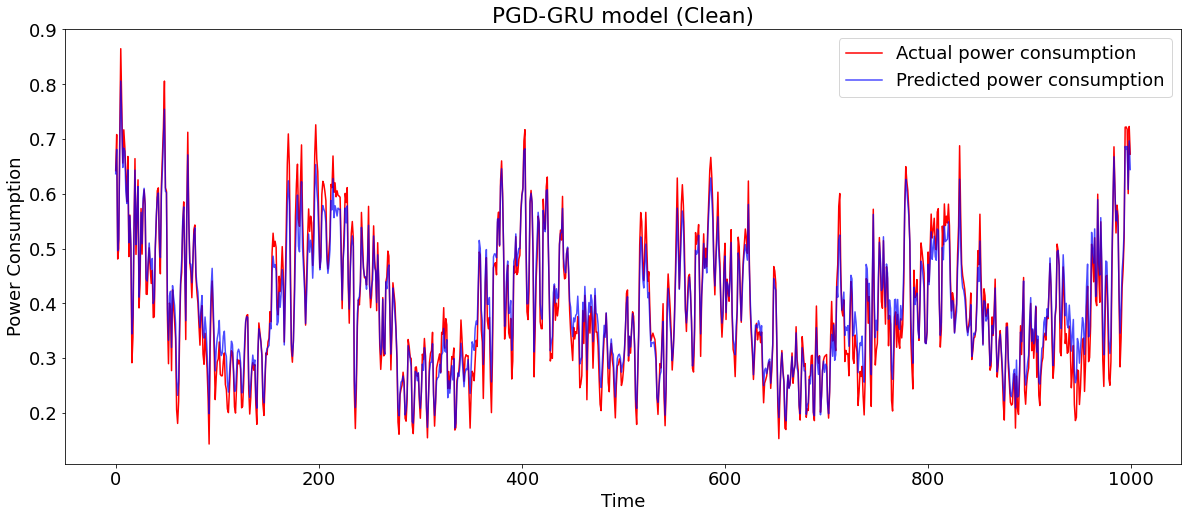

In [70]:
gru_pgd_predictions=get_result(pgd_gru, X_test, y_test, "PGD-GRU")
plot_predictions(y_test, gru_pgd_predictions, "PGD-GRU model (Clean)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - PGD-GRU:
R^2 Score: 0.8121197753615668
RMSE: 0.05525463512340396


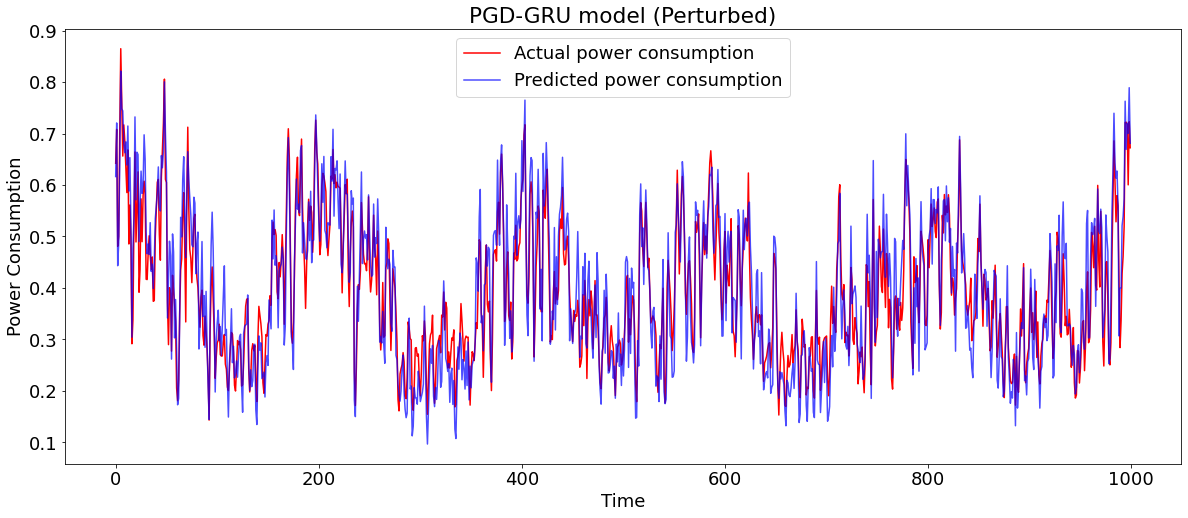

In [72]:
gru_pgd_predictions=get_result(pgd_gru, X_pgd_perturbed_gru, y_test, "PGD-GRU")
plot_predictions(y_test, gru_pgd_predictions, "PGD-GRU model (Perturbed)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

#### RNN

In [77]:
# Create perturbed training set
X_fgsm_perturbed_train = fgsm(X_train, y_train, epsilon=0.1)
X_new_rnn=np.concatenate((X_train,X_fgsm_perturbed_train))
fgsm_rnn=rnn(X_new_rnn,new_Y)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 23)                575       
                                                                 
 dropout_14 (Dropout)        (None, 23)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 24        
                                                                 
Total params: 599
Trainable params: 599
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
254/254 [==============================] - 2s 3ms/step - loss: 0.0231
Epoch 2/10
254/254 [==============================] - 1s 3ms/step - loss: 0.0077
Epoch 3/10
254/254 [==============================] - 1s 3ms/step - loss: 0.0054
Epoch 4/10
254/254 [==============================] - 1s 3ms/step - loss: 0.

Model - FGSM-RNN:
R^2 Score: 0.9197742892885492
RMSE: 0.03610646408398759


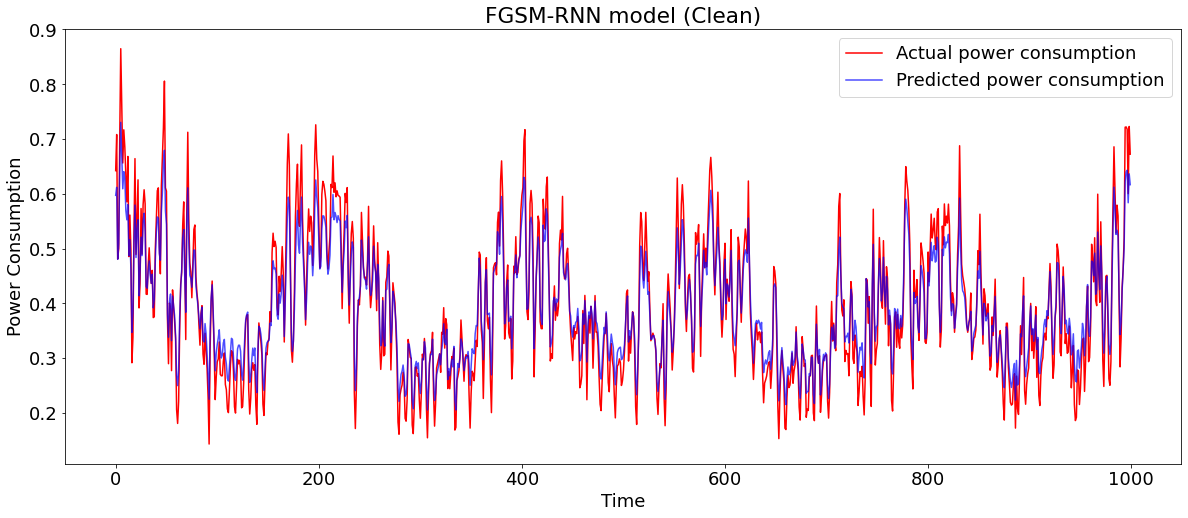

In [78]:
rnn_fgsm_predictions=get_result(fgsm_rnn, X_test, y_test, "FGSM-RNN")
plot_predictions(y_test, rnn_fgsm_predictions, "FGSM-RNN model (Clean)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - FGSM-RNN:
R^2 Score: 0.8448091632232072
RMSE: 0.05021820946953241


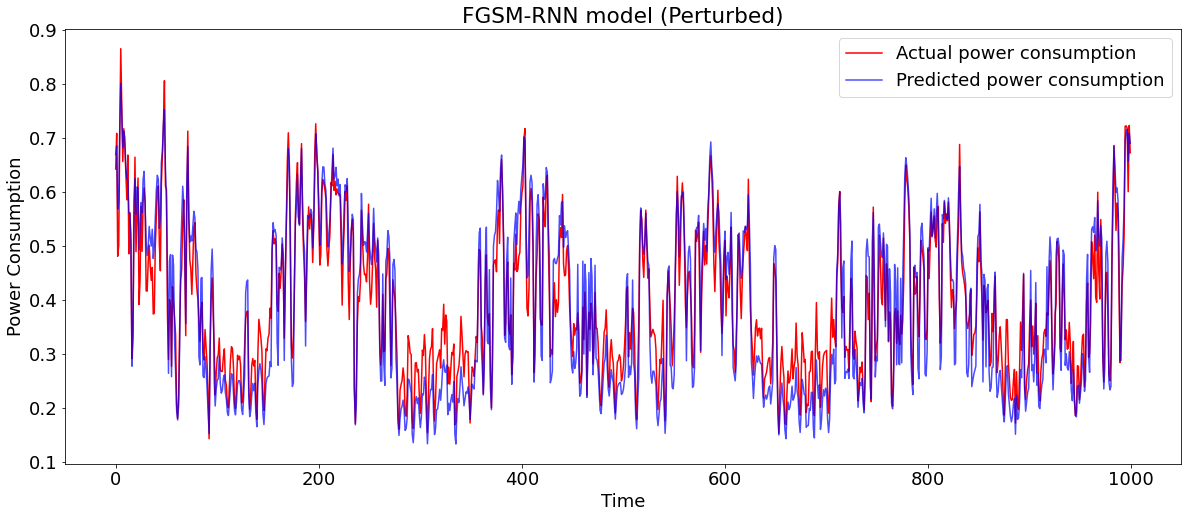

In [79]:
rnn_fgsm_predictions=get_result(fgsm_rnn, X_fgsm_perturbed_rnn, y_test, "FGSM-RNN")
plot_predictions(y_test, rnn_fgsm_predictions, "FGSM-RNN model (Perturbed)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

In [81]:
# Create perturbed training set
X_pgd_perturbed_train = pgd(5,0.1,0.05,X_train, y_train)
X_new_rnn=np.concatenate((X_train,X_pgd_perturbed_train))
pgd_rnn=rnn(X_new_rnn,new_Y)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 23)                575       
                                                                 
 dropout_15 (Dropout)        (None, 23)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                 24        
                                                                 
Total params: 599
Trainable params: 599
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
254/254 [==============================] - 2s 3ms/step - loss: 0.0117
Epoch 2/10
254/254 [==============================] - 1s 3ms/step - loss: 0.0049
Epoch 3/10
254/254 [==============================] - 1s 3ms/step - loss: 0.0040
Epoch 4/10
254/254 [==============================] - 1s 3ms/step - loss: 0.

Model - PGD-RNN:
R^2 Score: 0.9644821388585544
RMSE: 0.024024345557178462


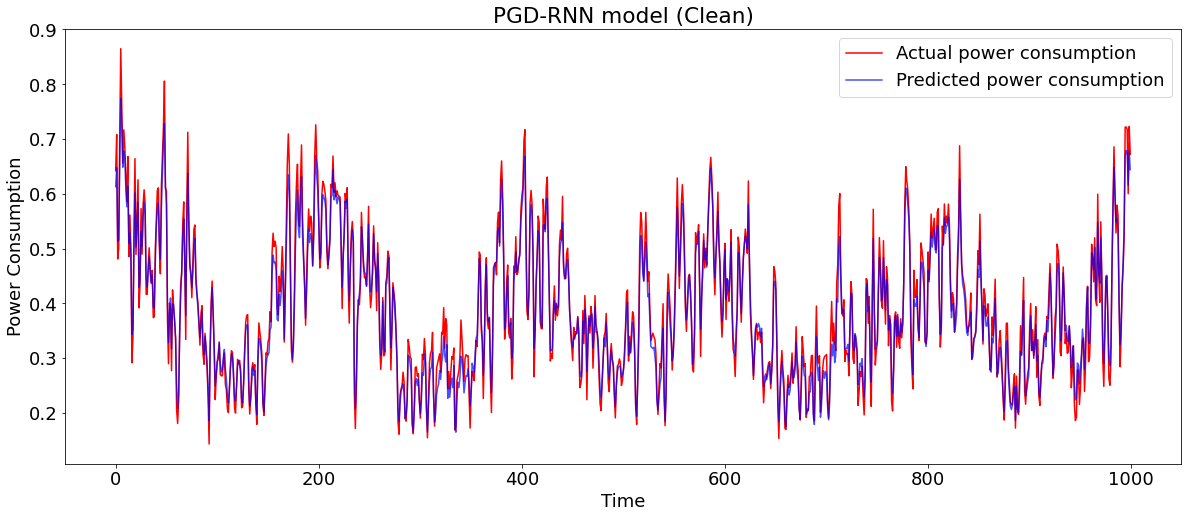

In [82]:
rnn_pgd_predictions=get_result(pgd_rnn, X_test, y_test, "PGD-RNN")
plot_predictions(y_test, rnn_pgd_predictions, "PGD-RNN model (Clean)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - PGD-RNN:
R^2 Score: 0.6397095673823947
RMSE: 0.0765163993227609


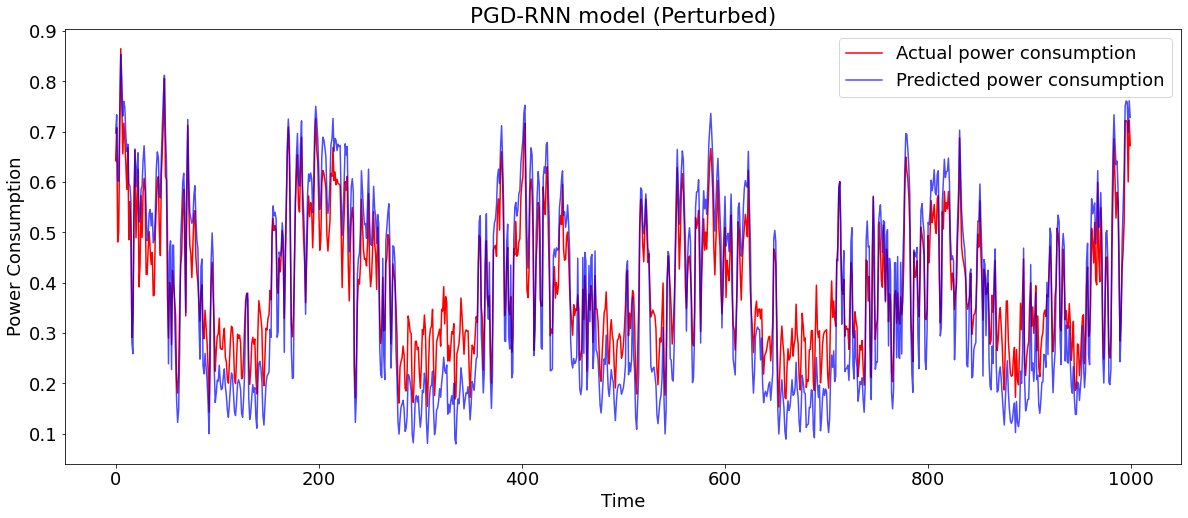

In [83]:
rnn_pgd_predictions=get_result(pgd_rnn, X_fgsm_perturbed_rnn, y_test, "PGD-RNN")
plot_predictions(y_test, rnn_pgd_predictions, "PGD-RNN model (Perturbed)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")